In [1]:
import zlib
import numpy as np
import pandas as pd
import sqlite3 as sql
from contextlib import contextmanager


_CMP = '_cmp'


@contextmanager
def open_db_connection(*, file, close=True,
                       lock=None, check_same_thread=False):
    """
    Safety wrapper for the database call.
    """

    if lock is not None:
        lock.acquire()

    con = sql.connect(database=file, check_same_thread=check_same_thread)

    try:
        yield con

    finally:
        if close:
            con.close()
        if lock is not None:
            lock.release()


def get_table_name(file):
    with open_db_connection(file=file, close=True) as con:
        res = pd.read_sql_query(sql="SELECT name FROM sqlite_master WHERE type ='table' AND name NOT LIKE 'sqlite_%'",
                                con=con)
        return res['name'].values


def rename_table(file, tables):
    old_names = get_table_name(file=file)

    with open_db_connection(file=file, close=True) as con:
        cur = con.cursor()
        for old in old_names:
            if old in tables:
                new = tables['old']
                cur.execute(f"ALTER TABLE `{old}` RENAME TO `{new}`")


def get_values_sql(*, file, table='db', columns=None, rows=-1,
                   values_only=False, squeeze_col=True, squeeze_row=True):
    """
    'i_samples' == i_samples_global
    """

    lock = None  # Lock is not necessary fo reading
    if columns is None:
        columns = '*'
    if isinstance(columns, str):
        columns = [columns]
    columns_str = ', '.join(map(str, columns))

    if isinstance(rows, int):
        rows = [rows]
    rows = np.array(rows)

    if rows[0] == -1:  # All samples
        with open_db_connection(file=file, close=True, lock=lock) as con:
            df = pd.read_sql_query(con=con, sql=f"SELECT {columns_str} FROM {table}")  # path_db

    else:
        rows_str = rows + 1  # Attention! Unlike in Python, SQL indices start at 1
        rows_str = ', '.join(map(str, rows_str))
        with open_db_connection(file=file, close=True, lock=lock) as con:
            df = pd.read_sql_query(sql=f"SELECT {columns_str} FROM {table} WHERE ROWID in ({rows_str})",
                                   index_col=rows, con=con)

    value_list = []
    if np.any(columns == ['*']):
        columns = df.columns.values

    if values_only:
        for col in columns:
            value = __decompress_values(value=df.loc[:, col].values, col=col)
            value_list.append(value)

        if len(df) == 1 and squeeze_row:
            for i in range(len(columns)):
                value_list[i] = value_list[i][0]

        if len(value_list) == 1 and squeeze_col:
            value_list = value_list[0]

        return value_list

    # Return pandas.DataFrame
    else:
        for col in columns:
            value = __decompress_values(value=df.loc[:, col].values, col=col)
            df.loc[:, col] = numeric2object_array(value)

        return df


def set_values_sql(*, file, table='db',
                   values, columns, rows=-1, lock=None):
    """
    Note: multidimensional numpy arrays have to be saved as flat to SQL otherwise the order is messed up
    values = ([...], [...], [...], ...)
    """

    # Handle rows argument
    if isinstance(rows, int):
        if rows == -1:
            rows = np.arange(len(values[0])).tolist()
        else:
            rows = [rows]

    rows_sql = (np.array(rows) + 1).tolist()  # Attention! Unlike in Python, SQL indices start at 1

    # Handle columns argument
    if isinstance(columns, str):
        columns = [columns]

    columns_str = '=?, '.join(map(str, columns))
    columns_str += '=?'

    values_rows_sql = change_tuple_order(values + (rows_sql,))
    values_rows_sql = list(values_rows_sql)
    query = f"UPDATE {table} SET {columns_str} WHERE ROWID=?"

    with open_db_connection(file=file, close=True, lock=lock) as con:
        cur = con.cursor()
        if len(values_rows_sql) == 1:
            cur.execute(query, values_rows_sql[0])
        else:
            cur.executemany(query, values_rows_sql)

        con.commit()


def df2sql(df, file, table='db', if_exists='fail', lock=None):
    """
    From DataFrame.to_sql():
        if_exists : {'fail', 'replace', 'append'}, default 'fail'
                   - fail: If table exists, do nothing.
                   - replace: If table exists, drop it, recreate it, and insert Measurements.
                   - append: If table exists, insert Measurements. Create if does not exist.
    """
    with open_db_connection(file=file, close=True, lock=lock) as con:
        df.to_sql(name=table, con=con, if_exists=if_exists, index=False)


# Helper
# Image Compression <-> Decompression
def __decompress_values(value, col):
    # SQL saves everything in binary form -> convert back to numeric, expect the columns which are marked as CMP
    if isinstance(value[0], bytes) and col[-4:] != _CMP:
        if col in ['i_world', 'i_sample', 'n_obstacles']:
            value = np.array([np.frombuffer(v, dtype=int) for v in value], dtype=int)
        elif col in ['rectangle_pos', 'rectangle_position', 'rectangle_size']:
            value = np.array([np.frombuffer(v, dtype=int) for v in value], dtype=object)
        else:
            value = np.array([np.frombuffer(v, dtype=float) for v in value])
        value = np.squeeze(value)

    return value


def change_tuple_order(tpl):
    return tuple(map(lambda *tt: tuple(tt), *tpl))


def numeric2object_array(arr):
    n = arr.shape[0]
    arr_obj = np.zeros(n, dtype=object)
    for i in range(n):
        arr_obj[i] = arr[i]

    return arr_obj


def object2numeric_array(arr):
    s = np.shape(arr)
    arr = np.array([v for v in np.ravel(arr)])
    arr = np.reshape(arr, s + np.shape(arr)[1:])
    return arr


def initialize_array(shape, mode='zeros', dtype=None, order='c'):

    if mode == 'zeros':
        return np.zeros(shape, dtype=dtype, order=order)
    elif mode == 'ones':
        return np.ones(shape, dtype=dtype, order=order)
    elif mode == 'empty':
        return np.empty(shape, dtype=dtype, order=order)
    elif mode == 'random':
        return np.random.random(shape).astype(dtype=dtype, order=order)
    else:
        raise ValueError(f"Unknown initialization method {mode}")


def __dim_voxels(n_voxels, n_dim=None):
    if np.size(n_voxels) == 1:
        try:
            n_voxels = tuple(n_voxels)
        except TypeError:
            n_voxels = (n_voxels,)
        n_voxels *= n_dim
    else:
        n_voxels = tuple(n_voxels)

    return n_voxels


def image_array_shape(n_voxels, n_samples=None, n_dim=None, n_channels=None):
    """
    Helper to set the shape for an image array.
    n_samples=100,  n_voxels=64,          n_dim=2,    n_channels=None  ->  (100, 64, 64)
    n_samples=100,  n_voxels=64,          n_dim=3,    n_channels=2     ->  (100, 64, 64, 64, 2)
    n_samples=None, n_voxel=(10, 11, 12), n_dim=None, n_channels=None  ->  (10, 11, 12)
    """

    shape = __dim_voxels(n_voxels=n_voxels, n_dim=n_dim)

    if n_samples is not None:
        shape = (n_samples,) + shape
    if n_channels is not None:
        shape = shape + (n_channels,)

    return shape


def initialize_image_array(n_voxels, n_dim=None, n_samples=None, n_channels=None,
                           dtype=bool, initialization='zeros'):
    shape = image_array_shape(n_voxels=n_voxels, n_dim=n_dim, n_samples=n_samples, n_channels=n_channels)
    return initialize_array(shape=shape, mode=initialization, dtype=dtype)


# Image Compression <-> Decompression
def img2compressed(img, n_dim=-1, level=9):
    """
    Compress the given image with the zlib routine to a binary string.
    Level of compression can be adjusted. A timing with respect to different compression levels for decompression showed
    no difference, so the highest level is default, this corresponds to the largest compression.
    For compression it is slightly slower but this happens just once and not during keras training, so the smaller
    needed memory was favoured.
    Alternative:
    <-> use numpy sparse for the world images, especially in 3d  -> zlib is more effective and more general
    """

    if n_dim == -1:
        return zlib.compress(img.tobytes(), level=level)
    else:
        shape = img.shape[:-n_dim]
        img_cmp = np.empty(shape, dtype=object)
        for idx in np.ndindex(*shape):
            img_cmp[idx] = zlib.compress(img[idx, ...].tobytes(), level=level)
        return img_cmp


def compressed2img(img_cmp, n_voxels, n_dim=None, n_channels=None, dtype=bool):
    """
    Decompress the binary string back to an image of given shape
    """

    shape = np.shape(img_cmp)

    if shape:
        n_samples = np.size(img_cmp)
        img_arr = initialize_image_array(n_voxels=n_voxels, n_dim=n_dim, n_samples=n_samples, n_channels=n_channels,
                                         dtype=dtype)
        for i in range(n_samples):
            img_arr[i, ...] = np.fromstring(zlib.decompress(img_cmp[i]), dtype=dtype).reshape(
                image_array_shape(n_voxels=n_voxels, n_dim=n_dim, n_channels=n_channels))
        return img_arr

    else:
        return np.fromstring(zlib.decompress(img_cmp), dtype=dtype).reshape(
            image_array_shape(n_voxels=n_voxels, n_dim=n_dim, n_channels=n_channels))



C:\Users\sereen\AppData\Local\Temp/ipykernel_8968/2894094313.py:276: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  img_arr[i, ...] = np.fromstring(zlib.decompress(img_cmp[i]), dtype=dtype).reshape(


(5, 1, 4)
(10000, 64, 64)


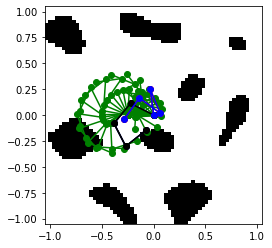

In [2]:
import numpy as np
import matplotlib.pyplot as plt



file = './StaticArm04.db'
# TODO change to you own file path

n_voxels = 64
voxel_size = 2.10 / 64     # in m
extent = [-1.05, +1.05, -1.05, +1.05]  # in m
limb_length = 0.25  # m
n_waypoints = 20  # start + 20 inner points + end
n_dim = 2
n_dof = 4
n_worlds = 10000
# n_paths_per_world = 1000

worlds = get_values_sql(file=file, table='worlds')
obstacle_images = compressed2img(img_cmp=worlds.obst_img_cmp.values, n_voxels=n_voxels, n_dim=n_dim)

paths = get_values_sql(file=file, table='paths', rows=[0, 1, 2, 1000, 2000])
q_start = object2numeric_array(paths.q_start.values)
q_start = q_start.reshape(-1, 1, n_dof)
q_end= object2numeric_array(paths.q_end.values)
q_end = q_end.reshape(-1, 1, n_dof)
q_paths = object2numeric_array(paths.q_path.values)
q_paths = q_paths.reshape(-1, n_waypoints, n_dof)

#print(q_paths[0])
print(q_start.shape)

# Plot an example
i = 3
#i_world = paths.i_world[i]


def forward_kinematic(q):
    q = np.cumsum(q, axis=-1)
    x = np.concatenate([q[..., np.newaxis], q[..., np.newaxis]], axis=-1)
    x[..., 0] = np.cos(x[..., 0])*limb_length
    x[..., 1] = np.sin(x[..., 1])*limb_length

    shape = np.array(q.shape + (2,))
    shape[-2] = 1
    x = np.concatenate([np.zeros(shape), x], axis=-2)
    x = np.cumsum(x, axis=-2)
    return x

print(obstacle_images.shape)
#print(q_paths)
# Plot an example
fig, ax = plt.subplots()
ax.imshow(obstacle_images[0].T, origin='lower', extent=extent, cmap='binary')
x = forward_kinematic(q_start[i])
ax.plot(*x[0].T, color='k', marker='o', zorder=22)
x = forward_kinematic(q_end[i])
ax.plot(*x[0].T, color='blue', marker='o', zorder=22)
#print(q_paths[i])

x = forward_kinematic(q_paths[i])
ax.plot(*x[0].T, color='black', marker='o', zorder=10)
ax.plot(*x[1].T, color='green', marker='o', zorder=10)
ax.plot(*x[2].T, color='green', marker='o', zorder=10)
ax.plot(*x[3].T, color='green', marker='o', zorder=10)
ax.plot(*x[4].T, color='green', marker='o', zorder=10)
ax.plot(*x[5].T, color='green', marker='o', zorder=10)
ax.plot(*x[6].T, color='green', marker='o', zorder=10)
ax.plot(*x[7].T, color='green', marker='o', zorder=10)
ax.plot(*x[8].T, color='green', marker='o', zorder=10)
ax.plot(*x[9].T, color='green', marker='o', zorder=10)
ax.plot(*x[10].T, color='green', marker='o', zorder=10)
ax.plot(*x[11].T, color='green', marker='o', zorder=10)
ax.plot(*x[12].T, color='green', marker='o', zorder=10)
ax.plot(*x[13].T, color='green', marker='o', zorder=10)
ax.plot(*x[14].T, color='green', marker='o', zorder=10)
ax.plot(*x[15].T, color='green', marker='o', zorder=10)
ax.plot(*x[16].T, color='green', marker='o', zorder=10)
ax.plot(*x[17].T, color='green', marker='o', zorder=10)
ax.plot(*x[18].T, color='green', marker='o', zorder=10)
ax.plot(*x[-1].T, color='red', marker='o', zorder=10)
h = ax.plot(*x[0].T, color='blue', marker='o', zorder=0)[0]

plt.savefig('collision in some samples.jpg')






In [3]:
import time
%matplotlib

n_waypoints = 20
fig, ax = plt.subplots()
x = forward_kinematic(q_paths[1])
time.sleep(15)
for i in range(n_waypoints):
    plt.cla()
    ax.imshow(obstacle_images[0].T, origin='lower', extent=extent, cmap='binary')
    h = ax.plot(*x[i].T, color='blue', marker='o', zorder=12)[0]
    plt.pause(0.01)
    
    


Using matplotlib backend: <object object at 0x000000D3348244A0>


In [3]:
def load_images_for_multiple_world(worlds_range, file, paths_per_world=325):
    
    """ Returns an array of tuples where each tuple contains:
        1. Obstacle image of the desired world with different start & end points
        2. Above image plus the path from start to end point
    """
    
    # Initial Parameters
    n_voxels = 64
    voxel_size = 10 / 64     # in m
    extent = [0, 10, 0, 10]  # in m
    n_waypoints = 20  # start + 20 inner points + end
    n_dim = 2
    n_paths_per_world = 1000
    n_worlds = 5000

    worlds = get_values_sql(file=file, table='worlds')
   
    #print(obstacle_image.shape)
    # always 1000 paths belong to one world
    # 0...999     -> world 0
    # 1000...1999 -> world 1
    # 2000...2999 -> world 2
    
    
    
    # Decompressing objects to images
    #path_images = compressed2img(img_cmp=paths.path_img_cmp.values, n_voxels=n_voxels, n_dim=n_dim)
   

    
    path_index= [x for x in range(0,325)]
    #print(obstacle_images.shape)
    #print(q_start.shape)
    input_images = []
    path_coordinates= []
    output_images = []
    #print(obstacle_images[0])
    for world_index in worlds_range:
        path_range_start  = world_index * paths_per_world 
        path_range_end = world_index * paths_per_world + paths_per_world 
        n_world_all_paths = [x for x in range(path_range_start, path_range_end)]
        obstacle_image = compressed2img(img_cmp=worlds.obst_img_cmp.values, n_voxels=n_voxels, n_dim=n_dim)[world_index]
        paths = get_values_sql(file=file, table='paths', rows=n_world_all_paths)
        q_start = object2numeric_array(paths.q_start.values)
        q_start = q_start.reshape(-1, 1, n_dof)
        q_end= object2numeric_array(paths.q_end.values)
        q_end = q_end.reshape(-1, 1, n_dof)
        q_paths = object2numeric_array(paths.q_path.values)
        q_paths = q_paths.reshape(-1, n_waypoints, n_dof)
        for i in path_index:
            z= np.ones((1,60), dtype=float)
            y= np.ones((1,60), dtype=float)
            new_q_end= np.append(q_end[i],y, axis=1)
            new_q_start= np.append(q_start[i],z, axis=1)
            x= np.ones((63,64),dtype=float)
            m = np.ones((63,64),dtype=float)
            new_q_end= np.append(new_q_end,x, axis=0)
            new_q_start= np.append(new_q_start,m, axis=0)
            input_images.append(np.concatenate((obstacle_image.T[:,:,np.newaxis], new_q_start.T[:,:,np.newaxis], new_q_end.T[:,:,np.newaxis]), axis=-1))
            output_images.append(obstacle_image.T[:,:,np.newaxis])
            path_coordinates.append(q_paths[i])      
    return input_images, output_images, path_coordinates
    

In [4]:
# Choosing worlds that doesn't have Arm obsticale collision
input_images, output_images, path_coordinates = load_images_for_multiple_world((0,2,4), file)
# Reshaping
input_images = np.reshape(input_images, (-1, 64, 64,3))
print("Input Images Shape after Reshaping: ",input_images.shape)


path_coords = np.reshape(np.array(path_coordinates), (-1, 20, 4))
print("Output Images Shape after Reshaping: ", path_coords.shape)

C:\Users\sereen\AppData\Local\Temp/ipykernel_8968/2894094313.py:276: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  img_arr[i, ...] = np.fromstring(zlib.decompress(img_cmp[i]), dtype=dtype).reshape(


Input Images Shape after Reshaping:  (975, 64, 64, 3)
Output Images Shape after Reshaping:  (975, 20, 4)


### the Arm in the ground truth dataset for 50% of the words coincide with the obsticals, need data preprocessing for the dataset




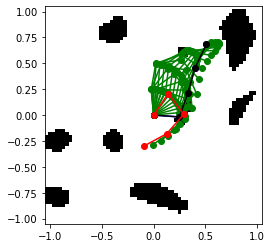

In [51]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
i =1100
ax.imshow((output_images[i]).astype(np.uint8), origin='lower', extent=extent, cmap='binary')



x = forward_kinematic(path_coordinates[i])
ax.plot(*x[0].T, color='black', marker='o', zorder=11)
ax.plot(*x[1].T, color='green', marker='o', zorder=10)
ax.plot(*x[2].T, color='green', marker='o', zorder=10)
ax.plot(*x[3].T, color='green', marker='o', zorder=10)
ax.plot(*x[4].T, color='green', marker='o', zorder=10)
ax.plot(*x[5].T, color='green', marker='o', zorder=10)
ax.plot(*x[6].T, color='green', marker='o', zorder=10)
ax.plot(*x[7].T, color='green', marker='o', zorder=10)
ax.plot(*x[8].T, color='green', marker='o', zorder=10)
ax.plot(*x[9].T, color='green', marker='o', zorder=10)
ax.plot(*x[10].T, color='green', marker='o', zorder=10)
ax.plot(*x[11].T, color='green', marker='o', zorder=10)
ax.plot(*x[12].T, color='green', marker='o', zorder=10)
ax.plot(*x[13].T, color='green', marker='o', zorder=10)
ax.plot(*x[14].T, color='green', marker='o', zorder=10)
ax.plot(*x[15].T, color='green', marker='o', zorder=10)
ax.plot(*x[16].T, color='green', marker='o', zorder=10)
ax.plot(*x[17].T, color='green', marker='o', zorder=10)
ax.plot(*x[18].T, color='green', marker='o', zorder=10)
ax.plot(*x[-1].T, color='red', marker='o', zorder=11)
h = ax.plot(*x[0].T, color='blue', marker='o', zorder=0)[0]
plt.savefig('overlap_transpose.jpg')

In [5]:

from sklearn.model_selection import train_test_split
features_train, features_test, obst_train,obst_test, labels_train, labels_test = train_test_split(input_images, output_images, path_coords, test_size= 0.2, random_state=42)
print(features_test.shape)
print(features_train.shape)


(195, 64, 64, 3)
(780, 64, 64, 3)


In [6]:
import os
import numpy as np
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
import datetime
import matplotlib.pyplot as plt

In [7]:
image_width = 64
image_height = 64
channels = 3

In [8]:
input_layer= tf.keras.layers.Input((image_width, image_height, channels))
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(input_layer)
print(input_layer.shape)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.1)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.1)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), padding='same', strides=(2, 2))(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.1)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), padding='same', strides=(2, 2))(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.1)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), padding='same', strides=(2, 2))(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), padding='same', strides=(2, 2))(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
#print(c9.shape)


output_layer = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

flat = tf.keras.layers.Flatten()(output_layer)
d3 = tf.keras.layers.Dense(80)(flat)
    
coordinates_output = tf.keras.layers.Reshape((20,4))(d3)


print(coordinates_output.shape)

(None, 64, 64, 3)
(None, 20, 4)


In [13]:
model = tf.keras.Model(inputs=input_layer, outputs=coordinates_output)
log_dir = "C:/Robot_motion_planing/adlr_team_11/Anshasi/log/"

model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mean_absolute_error', metrics=['mean_squared_error'])
history = model.fit(features_train, labels_train, epochs=100)
model.summary()
print("------------Building the Model finished------------------")
model.save('C:/Robot_motion_planing/adlr_team_11/Anshasi/Arm_3_worlds-100-epochs')

Epoch 1/100
25/25 [==============================] - 15s 370ms/step - loss: 1.4521 - mean_squared_error: 2.9194
Epoch 2/100
25/25 [==============================] - 7s 270ms/step - loss: 1.4125 - mean_squared_error: 2.7263
Epoch 3/100
25/25 [==============================] - 7s 272ms/step - loss: 1.3421 - mean_squared_error: 2.5728
Epoch 4/100
25/25 [==============================] - 7s 272ms/step - loss: 1.2682 - mean_squared_error: 2.3842
Epoch 5/100
25/25 [==============================] - 7s 271ms/step - loss: 1.2427 - mean_squared_error: 2.3090
Epoch 6/100
25/25 [==============================] - 7s 276ms/step - loss: 1.2168 - mean_squared_error: 2.2170
Epoch 7/100
25/25 [==============================] - 7s 269ms/step - loss: 1.1694 - mean_squared_error: 2.0666
Epoch 8/100
25/25 [==============================] - 7s 269ms/step - loss: 1.1065 - mean_squared_error: 1.8685
Epoch 9/100
25/25 [==============================] - 7s 276ms/step - loss: 1.0042 - mean_squared_error: 1.5913


In [ ]:
loss_train = history.history['loss']
#loss_val = history.history['mean_squared_error']
ephocs= range(0,100)
plt.plot(ephocs,loss_train, 'g', label= 'training loss')
#plt.plot(ephocs,loss_train, 'b', label= 'testing loss')
plt.title( 'Training loss 3 worlds')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_3_worlds_Arm.jpg')
plt.show()

In [7]:
model = keras.models.load_model('C:/Robot_motion_planing/adlr_team_11/Anshasi/Arm_3_worlds')

In [14]:
model.evaluate(features_test,labels_test)
model.evaluate(features_train,labels_train)

25/25 [==============================] - 2s 82ms/step - loss: 0.2210 - mean_squared_error: 0.0943


[0.22102642059326172, 0.09426269680261612]

In [29]:
features_test = np.reshape(np.array(features_test), (-1,64, 64,3))
print("Output Images Shape after Reshaping: ", features_test.shape)

Output Images Shape after Reshaping:  (65, 64, 64, 3)


In [8]:
predectid = model.predict(features_test)

Input Images Shape after Reshaping:  (585, 64, 64)


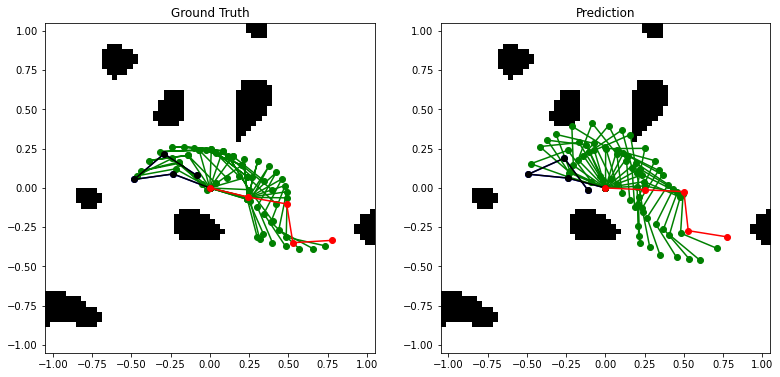

In [13]:

features_test = np.reshape(features_test, (-1, 64, 64))
obst_test= np.reshape(obst_test, (-1,64,64))
print("Input Images Shape after Reshaping: ",features_test.shape)
i=170
fig, ax = plt.subplots(1,2, figsize=(13,13))

ax[0].imshow(obst_test[i], origin='lower', extent=extent, cmap='binary')


x = forward_kinematic(labels_test[i])
ax[0].plot(*x[0].T, color='black', marker='o', zorder=11)
ax[0].plot(*x[1].T, color='green', marker='o', zorder=10)
ax[0].plot(*x[2].T, color='green', marker='o', zorder=10)
ax[0].plot(*x[3].T, color='green', marker='o', zorder=10)
ax[0].plot(*x[4].T, color='green', marker='o', zorder=10)
ax[0].plot(*x[5].T, color='green', marker='o', zorder=10)
ax[0].plot(*x[6].T, color='green', marker='o', zorder=10)
ax[0].plot(*x[7].T, color='green', marker='o', zorder=10)
ax[0].plot(*x[8].T, color='green', marker='o', zorder=10)
ax[0].plot(*x[9].T, color='green', marker='o', zorder=10)
ax[0].plot(*x[10].T, color='green', marker='o', zorder=10)
ax[0].plot(*x[11].T, color='green', marker='o', zorder=10)
ax[0].plot(*x[12].T, color='green', marker='o', zorder=10)
ax[0].plot(*x[13].T, color='green', marker='o', zorder=10)
ax[0].plot(*x[14].T, color='green', marker='o', zorder=10)
ax[0].plot(*x[15].T, color='green', marker='o', zorder=10)
ax[0].plot(*x[16].T, color='green', marker='o', zorder=10)
ax[0].plot(*x[17].T, color='green', marker='o', zorder=10)
ax[0].plot(*x[18].T, color='green', marker='o', zorder=10)
ax[0].plot(*x[-1].T, color='red', marker='o', zorder=11)
h = ax[0].plot(*x[0].T, color='blue', marker='o', zorder=0)[0]
ax[0].set_title('Ground Truth')
ax[1].imshow(obst_test[i], origin='lower', extent=extent, cmap='binary')
x = forward_kinematic(predectid[i])
ax[1].plot(*x[0].T, color='black', marker='o', zorder=11)
ax[1].plot(*x[1].T, color='green', marker='o', zorder=10)
ax[1].plot(*x[2].T, color='green', marker='o', zorder=10)
ax[1].plot(*x[3].T, color='green', marker='o', zorder=10)
ax[1].plot(*x[4].T, color='green', marker='o', zorder=10)
ax[1].plot(*x[5].T, color='green', marker='o', zorder=10)
ax[1].plot(*x[6].T, color='green', marker='o', zorder=10)
ax[1].plot(*x[7].T, color='green', marker='o', zorder=10)
ax[1].plot(*x[8].T, color='green', marker='o', zorder=10)
ax[1].plot(*x[9].T, color='green', marker='o', zorder=10)
ax[1].plot(*x[10].T, color='green', marker='o', zorder=10)
ax[1].plot(*x[11].T, color='green', marker='o', zorder=10)
ax[1].plot(*x[12].T, color='green', marker='o', zorder=10)
ax[1].plot(*x[13].T, color='green', marker='o', zorder=10)
ax[1].plot(*x[14].T, color='green', marker='o', zorder=10)
ax[1].plot(*x[15].T, color='green', marker='o', zorder=10)
ax[1].plot(*x[16].T, color='green', marker='o', zorder=10)
ax[1].plot(*x[17].T, color='green', marker='o', zorder=10)
ax[1].plot(*x[18].T, color='green', marker='o', zorder=10)
ax[1].plot(*x[-1].T, color='red', marker='o', zorder=11)
h = ax[1].plot(*x[0].T, color='blue', marker='o', zorder=0)[0]
ax[1].set_title('Prediction')
plt.savefig('170.jpg')

In [37]:
import time
%matplotlib

features_test = np.reshape(features_test, (-1, 64, 64))
obst_test= np.reshape(obst_test, (-1,64,64))

i=5
n_waypoints = 20
fig, ax = plt.subplots()
x = forward_kinematic(labels_test[i])
time.sleep(10)
for i in range(n_waypoints):
    plt.cla()
    ax.imshow(obst_test[1], origin='lower', extent=extent, cmap='binary')
    h = ax.plot(*x[i].T, color='blue', marker='o', zorder=12)[0]
    plt.pause(0.01)
    time.sleep(0.1)
    

Using matplotlib backend: QtAgg
